## HW 5 - Question 2


In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset, load_metric
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
import copy
import torch.nn as nn
from torch.nn.utils import prune

In [ ]:
train_df = pd.read_csv('/content/Train-word.csv', sep='\t')
train_df.reset_index(drop=True, inplace=True)
val_df = pd.read_csv('/content/Val-word.csv', sep='\t')
val_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv('/content/Test-word.csv', sep='\t')
test_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.head()

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7266 entries, 0 to 7265
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     7266 non-null   object
 1   hypothesis  7266 non-null   object
 2   label       7266 non-null   object
dtypes: object(3)
memory usage: 170.4+ KB


<Axes: title={'center': 'Classes Distribution in Train Data'}>

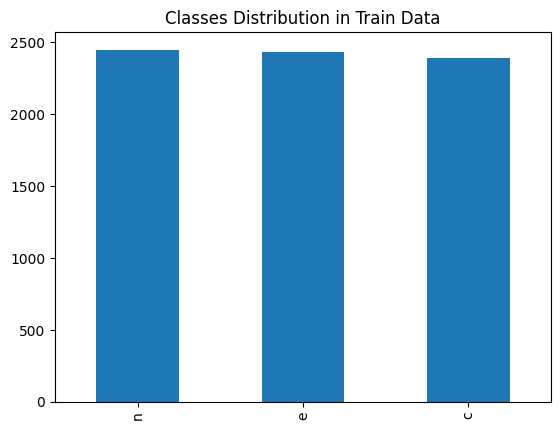

In [ ]:
train_df.info()
train_df['label'].value_counts().plot(kind="bar",title='Classes Distribution in Train Data')

In [ ]:
train_df.groupby('label').count()

,premise,hypothesis
label,,
c,2389,2389
e,2429,2429
n,2448,2448


In [ ]:
test_df.head()

,premise,hypothesis,label,hard(hypothesis),hard(overlap)
0,دوران امامت امام صادق علیه السلام، مصادف است ب...,امام سجاد (ع) در دورانی امامت کردند که همزمان ...,c,0,1
1,دوران امامت امام صادق علیه السلام، مصادف است ب...,دستگاه فاسد حکومتی با صرف هزینه های هنگفت، سعی...,n,1,0
2,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,دوران محنت اهل بیت پس از شهادت امام رضا(ع) آغا...,e,0,0
3,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,بعد از به شهادت رسیدن امام هادی(ع) دوران محنت ...,c,1,1
4,با شهادت امام رضا(ع) مرحله جدیدی از تلاش ائمه ...,حضرت جواد(ع) در سال ۱۹۵ هجری در مدینه ولادت یافت.,n,1,0


In [ ]:
test_df.drop(['hard(hypothesis)', 'hard(overlap)'], axis=1 , inplace = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     1564 non-null   object
 1   hypothesis  1564 non-null   object
 2   label       1564 non-null   object
dtypes: object(3)
memory usage: 36.8+ KB


<Axes: title={'center': 'Classes Distribution in Test Data'}>

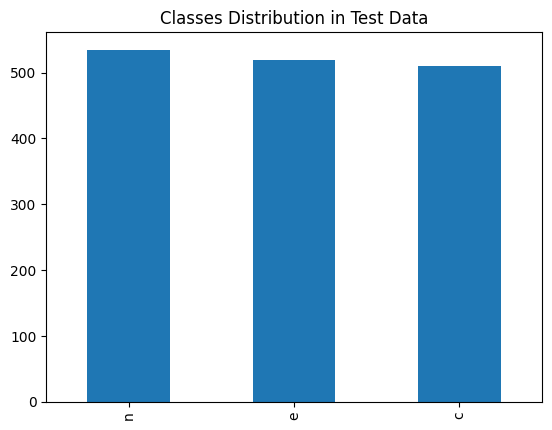

In [ ]:
test_df.info()
test_df['label'].value_counts().plot(kind="bar",title='Classes Distribution in Test Data')

In [ ]:
test_df.groupby('label').count()

,premise,hypothesis
label,,
c,510,510
e,519,519
n,535,535


In [ ]:
val_df.head()

,premise,hypothesis,label
0,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,کتاب مگیستی (المجسطی) از آثار بطلمیوس است و از...,e
1,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,المجسطی (مگیستی)، یکی از کتاب های هرون از مکتب...,c
2,یکی از سرآمدانی که بر تارک علمی مدرسه اسکندریه...,ترجمه المجسطی، پایه تهیه جداول نجومی گردید که ...,n
3,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,کتاب کلمات قصار یا فصول، اثر بقراط است.,e
4,تاریخ پزشکی یونانی با بقراط معروف است. آثار طب...,جالینوس، نویسنده کتاب کلمات قصار بوده است.,c


In [ ]:
val_df.groupby('label').count()

,premise,hypothesis
label,,
c,499,499
e,515,515
n,523,523


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     1537 non-null   object
 1   hypothesis  1537 non-null   object
 2   label       1537 non-null   object
dtypes: object(3)
memory usage: 36.1+ KB


<Axes: title={'center': 'Classes Distribution in Validation Data'}>

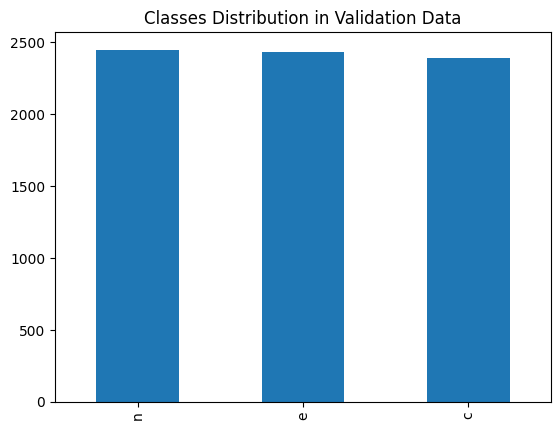

In [ ]:
val_df.info()
train_df['label'].value_counts().plot(kind="bar",title='Classes Distribution in Validation Data')

In [ ]:
train_df['label'] = train_df['label'].replace({'e':0,'c':1,'n':2})
val_df['label'] = val_df['label'].replace({'e':0,'c':1,'n':2})
test_df['label'] = test_df['label'].replace({'e':0,'c':1,'n':2})

In [ ]:
config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", truncation=True, padding=True)
model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Maximum number of tokens in premise: 134
Maximum number of tokens in hypothesis: 55


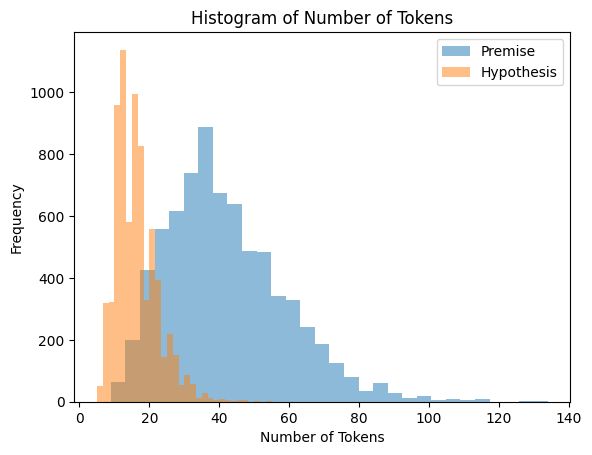

In [ ]:
max_tokens_premise = 0
token_counts_premise = []

for premise in train_df['premise']:
    tokens = tokenizer.tokenize(premise)
    token_count = len(tokens)
    max_tokens_premise = max(max_tokens_premise, token_count)
    token_counts_premise.append(token_count)

print("Maximum number of tokens in premise:", max_tokens_premise)

max_tokens_hypothesis = 0
token_counts_hypothesis = []

for hypothesis in train_df['hypothesis']:
    tokens = tokenizer.tokenize(hypothesis)
    token_count = len(tokens)
    max_tokens_hypothesis = max(max_tokens_hypothesis, token_count)
    token_counts_hypothesis.append(token_count)

print("Maximum number of tokens in hypothesis:", max_tokens_hypothesis)

plt.hist(token_counts_premise, bins=30, alpha=0.5, label='Premise')
plt.hist(token_counts_hypothesis, bins=30, alpha=0.5, label='Hypothesis')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens')
plt.legend()
plt.show()

In [ ]:
def batchTokenize(sample):
    return tokenizer(sample["premise"], sample["hypothesis"],  padding='max_length', truncation=True, max_length = 200)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(batchTokenize, batched=True)
val_dataset = val_dataset.map(batchTokenize, batched=True)
test_dataset = test_dataset.map(batchTokenize, batched=True)


Map:   0%|          | 0/7266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1537 [00:00<?, ? examples/s]

Map:   0%|          | 0/1564 [00:00<?, ? examples/s]

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
params = list(model.named_parameters())

print('*** Embedding Layer ***\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n*** First Transformer Out of 12 ***\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n*** Output Layer ***\n')
for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


*** Embedding Layer ***

bert.embeddings.word_embeddings.weight                  (100000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

*** First Transformer Out of 12 ***

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.attention.output.L

In [ ]:
!pip install transformers
!pip install --upgrade accelerate
!pip install -U sentence-transformers

In [ ]:
!pip install wandb
import wandb

In [ ]:
trainer_args = TrainingArguments(
    output_dir                  = "./result1",
    overwrite_output_dir        = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 1,
    learning_rate               = 3e-05,
    adam_epsilon                = 1e-08,
    num_train_epochs            = 3.0,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    report_to = 'wandb',
    )

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model                       = model,
    args                        = trainer_args,
    train_dataset               = train_dataset,
    eval_dataset                = val_dataset,
    compute_metrics             = compute_metrics,
    )

In [ ]:
%%wandb
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.529611,0.787899
2,0.647900,0.549396,0.811321


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.529611,0.787899
2,0.647900,0.549396,0.811321
3,0.318700,0.738854,0.811971


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.694365918636322,
 'eval_accuracy': 0.8260869565217391,
 'eval_runtime': 21.3583,
 'eval_samples_per_second': 73.227,
 'eval_steps_per_second': 4.588,
 'epoch': 3.0}

In [ ]:
prediction = trainer.predict(test_dataset)
predictions = prediction.predictions.argmax(-1)
print(classification_report(prediction.label_ids, predictions, labels=[0, 1, 2]))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       519
           1       0.77      0.74      0.75       510
           2       0.87      0.89      0.88       535

    accuracy                           0.83      1564
   macro avg       0.82      0.82      0.82      1564
weighted avg       0.82      0.83      0.83      1564



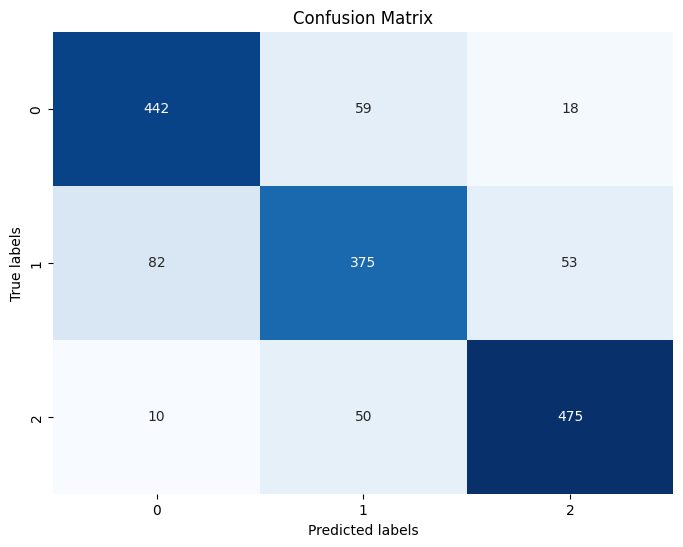

In [121]:
labels = prediction.label_ids
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model_copy = copy.deepcopy(model)

### Freeze first 9 embeding layers

In [ ]:
wandb.finish()

eval/accuracy,▅▁▄█
eval/loss,▂▆█▁
eval/runtime,█▁▆▄
eval/samples_per_second,▁▄▂█
eval/steps_per_second,▁▅▂█
train/epoch,▁▁▅▅███
train/global_step,▁▁▅▅███
train/learning_rate,█▁
train/loss,█▁
train/total_flos,▁
train/train_loss,▁


In [ ]:
trainer_args = TrainingArguments(
    output_dir                  = "./result1",
    overwrite_output_dir        = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 1,
    learning_rate               = 3e-05,
    adam_epsilon                = 1e-08,
    num_train_epochs            = 3.0,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    report_to = 'wandb',
    )

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model                       = model,
    args                        = trainer_args,
    train_dataset               = train_dataset,
    eval_dataset                = val_dataset,
    compute_metrics             = compute_metrics,
    )

In [ ]:
modules = [*model.bert.encoder.layer[:9]]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [ ]:
%%wandb
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.659488,0.711126


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.659488,0.711126
2,0.816600,0.584891,0.768380
3,0.528200,0.591800,0.783995


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5527648329734802,
 'eval_accuracy': 0.7896419437340153,
 'eval_runtime': 20.5783,
 'eval_samples_per_second': 76.002,
 'eval_steps_per_second': 4.762,
 'epoch': 3.0}

In [ ]:
prediction = trainer.predict(test_dataset)
predictions = prediction.predictions.argmax(-1)
print(classification_report(prediction.label_ids, predictions, labels=[0, 1, 2]))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.77      0.85      0.80       519
           1       0.73      0.67      0.70       510
           2       0.87      0.85      0.86       535

    accuracy                           0.79      1564
   macro avg       0.79      0.79      0.79      1564
weighted avg       0.79      0.79      0.79      1564



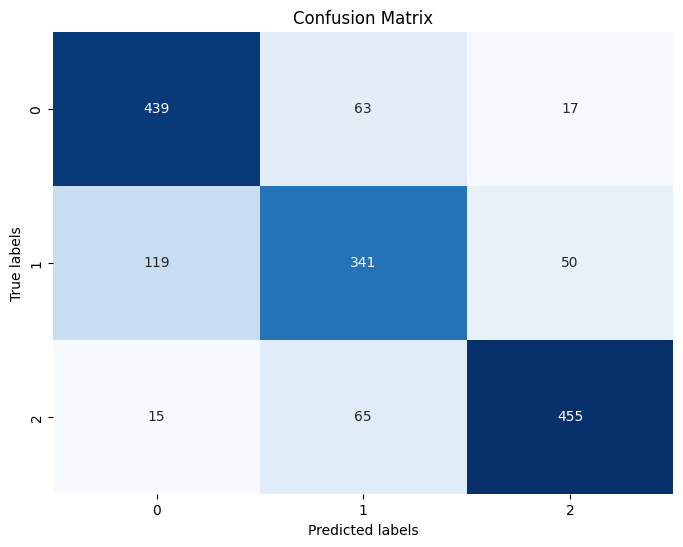

In [ ]:
labels = prediction.label_ids
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

### Freeze all 12 embeding layers

In [ ]:
wandb.finish()

In [ ]:
trainer_args = TrainingArguments(
    output_dir                  = "./result1",
    overwrite_output_dir        = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 1,
    learning_rate               = 3e-05,
    adam_epsilon                = 1e-08,
    num_train_epochs            = 3.0,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    report_to = 'wandb',
    )

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model                       = model,
    args                        = trainer_args,
    train_dataset               = train_dataset,
    eval_dataset                = val_dataset,
    compute_metrics             = compute_metrics,
    )

In [ ]:
modules = [*model.bert.encoder.layer[:12]]
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

In [ ]:
%%wandb
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.825214,0.593364
2,0.919200,0.787108,0.621991
3,0.690600,0.817040,0.612882


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.7709319591522217,
 'eval_accuracy': 0.6253196930946292,
 'eval_runtime': 18.8967,
 'eval_samples_per_second': 82.766,
 'eval_steps_per_second': 5.186,
 'epoch': 3.0}

In [ ]:
prediction = trainer.predict(test_dataset)
predictions = prediction.predictions.argmax(-1)
print(classification_report(prediction.label_ids, predictions, labels=[0, 1, 2]))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.55      0.85      0.67       519
           1       0.51      0.24      0.33       510
           2       0.79      0.77      0.78       535

    accuracy                           0.63      1564
   macro avg       0.62      0.62      0.59      1564
weighted avg       0.62      0.63      0.60      1564



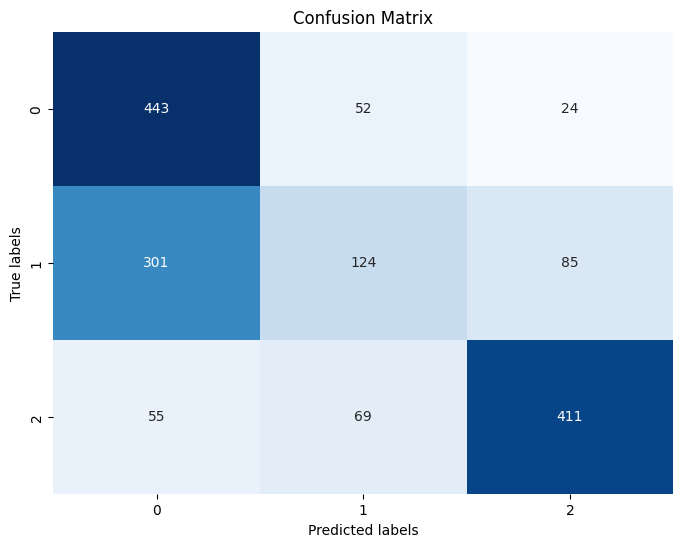

In [ ]:
labels = prediction.label_ids
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Part 2-1-4

In [ ]:
old_modules = model_copy.bert.encoder.layer
new_modules = nn.ModuleList()
for i in range(9):
    new_modules.append(old_modules[i])

model2 = copy.deepcopy(model_copy)
model2.bert.encoder.layer = new_modules

model2

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-8): 9 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
wandb.finish()

In [ ]:
trainer_args = TrainingArguments(
    output_dir                  = "./result1",
    overwrite_output_dir        = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 1,
    learning_rate               = 3e-05,
    adam_epsilon                = 1e-08,
    num_train_epochs            = 3.0,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    report_to = 'wandb',
    )

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model                       = model2,
    args                        = trainer_args,
    train_dataset               = train_dataset,
    eval_dataset                = val_dataset,
    compute_metrics             = compute_metrics,
    )

In [ ]:
%%wandb
trainer.train()

wandb: Currently logged in as: fateme-jlilii (fatemeh_nndl). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.550534,0.770982
2,0.697500,0.609692,0.798308
3,0.338500,0.725812,0.806766


<ipython-input-29-38b4304482f4>:18: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the r

In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.6709965467453003,
 'eval_accuracy': 0.819693094629156,
 'eval_runtime': 14.5214,
 'eval_samples_per_second': 107.703,
 'eval_steps_per_second': 6.749,
 'epoch': 3.0}

In [ ]:
prediction = trainer.predict(test_dataset)
predictions = prediction.predictions.argmax(-1)
print(classification_report(prediction.label_ids, predictions, labels=[0, 1, 2]))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.83      0.83       519
           1       0.75      0.74      0.74       510
           2       0.89      0.88      0.88       535

    accuracy                           0.82      1564
   macro avg       0.82      0.82      0.82      1564
weighted avg       0.82      0.82      0.82      1564



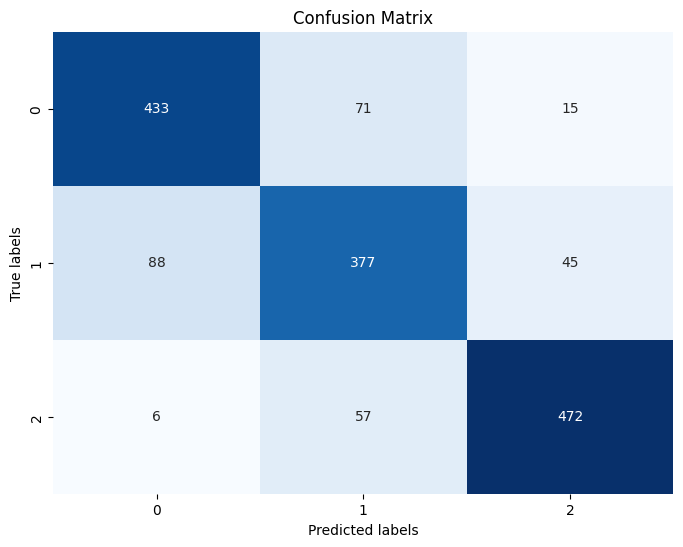

In [ ]:
labels = prediction.label_ids
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Part 2-1-5

In [ ]:
model_copy2 = copy.deepcopy(model_copy)

In [ ]:
wandb.finish()

In [ ]:
for name, param in model_copy2.named_parameters():
    print(f"Parameter name: {name}")

Parameter name: bert.embeddings.word_embeddings.weight
Parameter name: bert.embeddings.position_embeddings.weight
Parameter name: bert.embeddings.token_type_embeddings.weight
Parameter name: bert.embeddings.LayerNorm.weight
Parameter name: bert.embeddings.LayerNorm.bias
Parameter name: bert.encoder.layer.0.attention.self.query.weight
Parameter name: bert.encoder.layer.0.attention.self.query.bias
Parameter name: bert.encoder.layer.0.attention.self.key.weight
Parameter name: bert.encoder.layer.0.attention.self.key.bias
Parameter name: bert.encoder.layer.0.attention.self.value.weight
Parameter name: bert.encoder.layer.0.attention.self.value.bias
Parameter name: bert.encoder.layer.0.attention.output.dense.weight
Parameter name: bert.encoder.layer.0.attention.output.dense.bias
Parameter name: bert.encoder.layer.0.attention.output.LayerNorm.weight
Parameter name: bert.encoder.layer.0.attention.output.LayerNorm.bias
Parameter name: bert.encoder.layer.0.intermediate.dense.weight
Parameter name

In [ ]:
for layer_idx, layer in enumerate(model_copy2.bert.encoder.layer):
    for name, module in layer.named_modules():
        if "attention" in name and name.endswith("weight"):
            prune.random_unstructured(module, name=name, amount=0.5)

In [ ]:
trainer_args = TrainingArguments(
    output_dir                  = "./result1",
    overwrite_output_dir        = True,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    gradient_accumulation_steps = 1,
    learning_rate               = 3e-05,
    adam_epsilon                = 1e-08,
    num_train_epochs            = 3.0,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch",
    load_best_model_at_end      = True,
    metric_for_best_model       = "accuracy",
    report_to = 'wandb',
    )

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model                       = model_copy2,
    args                        = trainer_args,
    train_dataset               = train_dataset,
    eval_dataset                = val_dataset,
    compute_metrics             = compute_metrics,
    )

In [ ]:
%%wandb
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.650630,0.782043
2,0.355800,0.949961,0.765777


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.650630,0.782043
2,0.355800,0.949961,0.765777
3,0.181100,1.147190,0.780091


/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5734803676605225,
 'eval_accuracy': 0.7953964194373402,
 'eval_runtime': 11.0839,
 'eval_samples_per_second': 141.105,
 'eval_steps_per_second': 8.842,
 'epoch': 3.0}

In [ ]:
prediction = trainer.predict(test_dataset)
predictions = prediction.predictions.argmax(-1)
print(classification_report(prediction.label_ids, predictions, labels=[0, 1, 2]))

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.79      0.79       519
           1       0.71      0.71      0.71       510
           2       0.88      0.88      0.88       535

    accuracy                           0.80      1564
   macro avg       0.79      0.79      0.79      1564
weighted avg       0.80      0.80      0.80      1564



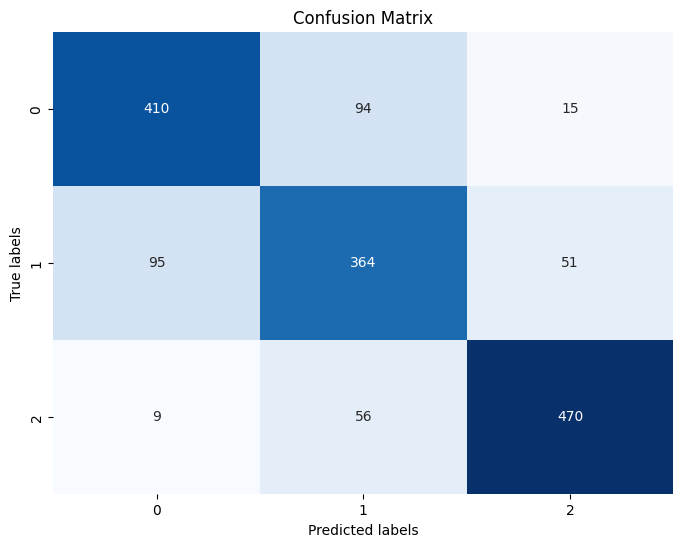

In [ ]:
labels = prediction.label_ids
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()